In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import cv2
from skimage.metrics import structural_similarity as ssim
import random
import torch.nn.functional as F
import matplotlib.cm as cm
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.image as mpimg

Original image shape: (512, 512)


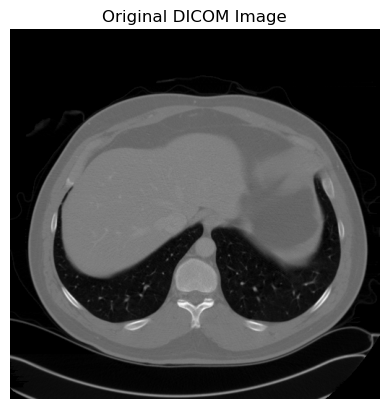

In [2]:
def load_original_dicom_image(dicom_file):
    """
    Load a single DICOM image without any filtering.

    Parameters:
    - dicom_file (str): The path to the DICOM file.

    Returns:
    - original_image (np.ndarray): The original DICOM image as a numpy array.
    """
    try:
        # Read the DICOM file
        dicom_data = pydicom.dcmread(dicom_file)
        original_image = dicom_data.pixel_array

        # Normalize the original image for better visualization
        original_image = original_image - np.min(original_image)
        original_image = (original_image / np.max(original_image)) * 255
        original_image = original_image.astype(np.float32) / 255.0

        return original_image

    except Exception as e:
        print(f"Error loading DICOM file {dicom_file}: {e}")
        return None


dicom_file_path =  '/home/23m1522/Wnet/archive/CHAOS_Train_Sets/Train_Sets/CT/5/DICOM_anon/i0020,0000b.dcm'  
  
original_image = load_original_dicom_image(dicom_file_path)

if original_image is not None:
    print("Original image shape:", original_image.shape)
    
    
    plt.imshow(original_image, cmap='gray')
    plt.title("Original DICOM Image")
    plt.axis('off')
    plt.show()

Processed image shape: (512, 512)


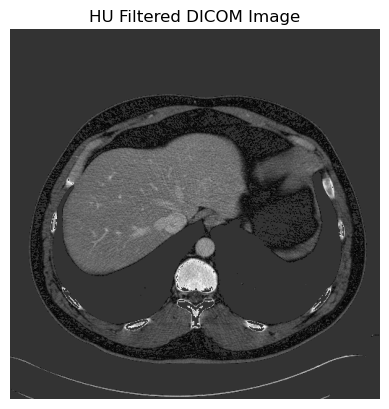

In [3]:
import os
import numpy as np
import pydicom

def process_single_dicom_image(dicom_file):
    """
    Load and preprocess a single DICOM image.

    Parameters:
    - dicom_file (str): The path to the DICOM file.

    Returns:
    - hu_filtered_image (np.ndarray): The normalized Hounsfield Units (HU) filtered image.
    """
    try:
        # Read the DICOM file
        dicom_data = pydicom.dcmread(dicom_file)
        image_data = dicom_data.pixel_array

        # Convert pixel values to Hounsfield Units (HU)
        intercept = dicom_data.RescaleIntercept if 'RescaleIntercept' in dicom_data else 0
        slope = dicom_data.RescaleSlope if 'RescaleSlope' in dicom_data else 1
        hu_image = image_data * slope + intercept

        # Apply HU range filter (-100 to 400 HU)
        hu_filtered_image = np.where((hu_image >= -100) & (hu_image <= 400), hu_image, 0)

        # Normalize HU filtered image to [0, 1]
        hu_filtered_image = hu_filtered_image - np.min(hu_filtered_image)
        hu_filtered_image = (hu_filtered_image / np.max(hu_filtered_image)) * 255
        hu_filtered_image = hu_filtered_image.astype(np.float32) / 255.0

        return hu_filtered_image

    except Exception as e:
        print(f"Error processing DICOM file {dicom_file}: {e}")
        return None
dicom_file = '/home/23m1522/Wnet/archive/CHAOS_Train_Sets/Train_Sets/CT/5/DICOM_anon/i0020,0000b.dcm'
hu_image = process_single_dicom_image(dicom_file)

if hu_image is not None:
    print("Processed image shape:", hu_image.shape)
    # Optionally visualize the processed image
    import matplotlib.pyplot as plt
    plt.imshow(hu_image, cmap='gray')
    plt.title("HU Filtered DICOM Image")
    plt.axis('off')
    plt.show()

In [4]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.sigmoid(self.psi(psi))
        return x * psi

In [5]:
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2D, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.decoder1 = self.upconv(512, 256)
        self.decoder1_conv = self.conv_block(512, 256)
        
        self.decoder2 = self.upconv(256, 128)
        self.decoder2_conv = self.conv_block(256, 128)
        
        self.decoder3 = self.upconv(128, 64)
        self.decoder3_conv = self.conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.att1 = AttentionGate(256, 256, 128)
        self.att2 = AttentionGate(128, 128, 64)
        self.att3 = AttentionGate(64, 64, 32)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        dec1 = self.decoder1(enc4)
        att1 = self.att1(dec1, enc3)
        dec1 = torch.cat((att1, enc3), dim=1)
        dec1 = self.decoder1_conv(dec1)

        dec2 = self.decoder2(dec1)
        att2 = self.att2(dec2, enc2)
        dec2 = torch.cat((att2, enc2), dim=1)
        dec2 = self.decoder2_conv(dec2)

        dec3 = self.decoder3(dec2)
        att3 = self.att3(dec3, enc1)
        dec3 = torch.cat((att3, enc1), dim=1)
        dec3 = self.decoder3_conv(dec3)
        
        return self.final_conv(dec3)    

In [6]:
class WNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(WNet, self).__init__()
        self.unet1 = UNet2D(in_channels, out_channels)
        self.fc_conv = nn.Conv2d(out_channels, num_classes, kernel_size=1, stride=1)
        self.unet2 = UNet2D(num_classes, in_channels)

    def forward(self, x):
        seg_output = self.unet1(x)
        fc_output = self.fc_conv(seg_output)
        softmax_output = F.softmax(fc_output, dim=1)
        reconstruction_output = self.unet2(softmax_output)
        return seg_output, softmax_output, reconstruction_output


In [7]:
def soft_ncuts_loss(output, weight_matrix):
    clusters = output.shape[1]
    P = torch.softmax(output, dim=1)
    cut_value = 0

    for k in range(clusters):
        P_k = P[:, k, :, :]
        cut_value += torch.sum(weight_matrix[:, k, :, :] * P_k)

    weight_sum = weight_matrix.sum(dim=1, keepdim=True)
    return (cut_value.mean() / weight_sum.squeeze(1).mean())

# SSIM Loss
def ssim_loss(img1, img2):
    img1_np = img1.squeeze(1).cpu().detach().numpy()
    img2_np = img2.squeeze(1).cpu().detach().numpy()
    batch_ssim_loss = 0

    for i in range(img1_np.shape[0]):
        win_size = min(7, min(img1_np[i].shape))
        ssim_val = ssim(img1_np[i], img2_np[i], data_range=1, win_size=win_size)
        batch_ssim_loss += (1 - ssim_val)

    return batch_ssim_loss / img1_np.shape[0]

In [8]:
device ='cpu'

In [9]:
import torch

# Define or import your W-Net model architecture
# from your_wnet_file import WNet  # Uncomment if WNet is defined in a separate file

# Initialize a new instance of your W-Net model
model = WNet(1,64,10)  # Ensure this matches the original model architecture used for saving

# Path to the saved model

model_path = '/home/23m1522/Wnet/archive/wnet_weights.pth'
state_dict=torch.load(model_path)
# Load the saved state dictionary into the model
model.load_state_dict(state_dict)

# Move model to GPU if available
model.to( "cpu")

# Set the model to evaluation mode if using it for inference
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_3749534/1949316281.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(model_path)


In [10]:
dicom_file_path = '/home/23m1522/Wnet/archive/CHAOS_Train_Sets/Train_Sets/CT/5/DICOM_anon/i0020,0000b.dcm'  
hu_image = process_single_dicom_image(dicom_file_path) 
ground = mpimg.imread("/home/23m1522/Wnet/archive/CHAOS_Train_Sets/Train_Sets/CT/5/Ground/liver_GT_020.png")

Standard deviations for each cluster:
Cluster 0: Standard Deviation = 0.02690875716507435
Cluster 1: Standard Deviation = 0.2558864653110504
Cluster 2: Standard Deviation = 0.0171805489808321
Cluster 3: Standard Deviation = 0.029570190235972404
Cluster 4: Standard Deviation = 0.037748754024505615
Cluster 5: Standard Deviation = 0.03408172354102135
Cluster 6: Standard Deviation = 0.052640922367572784
Cluster 7: Standard Deviation = 0.010219890624284744
Cluster 8: Standard Deviation = 0.04446309804916382
Cluster 9: Standard Deviation = 0.02176024205982685
Cluster with max standard deviation (likely liver): 1
Cluster with min standard deviation (likely background): 7


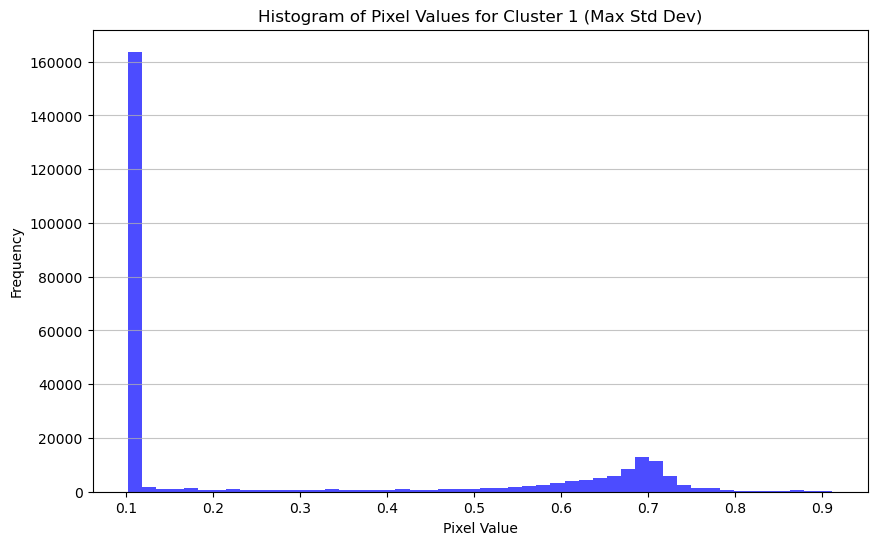

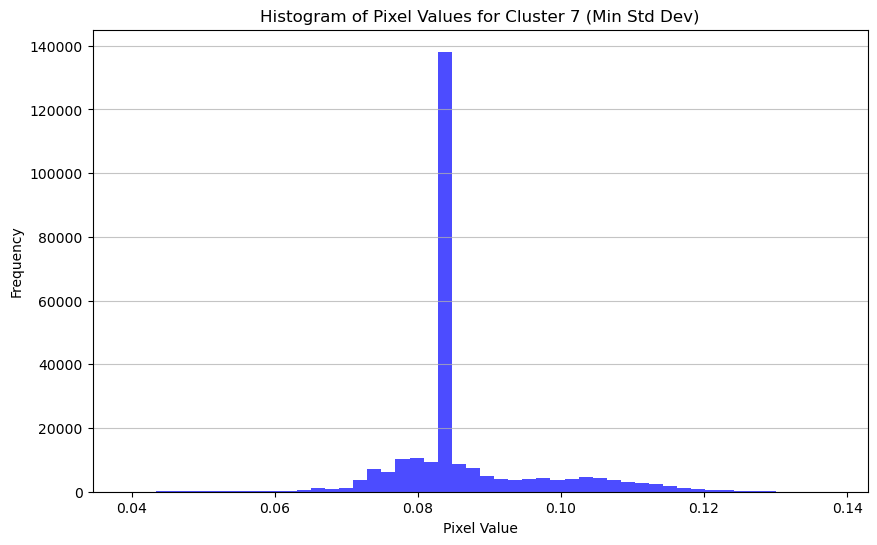

Larger Peak: 0.11328125 at height 144683
Smaller Peak: 0.6953125 at height 3279
First Minimum before smaller peak (Threshold for >): 0.63671875


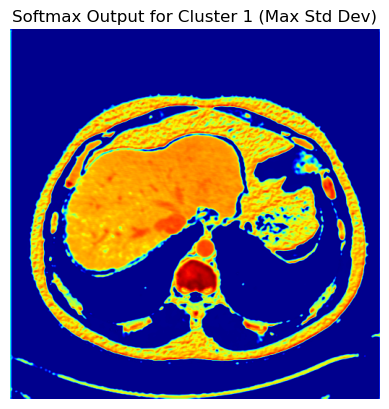

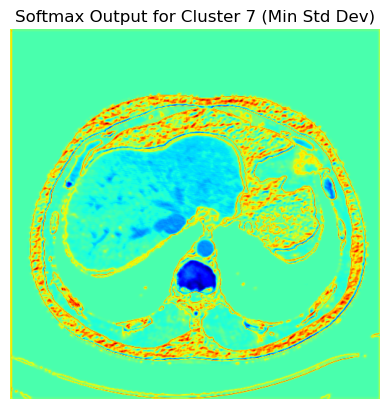

centroid of binary maks is (250.46583033908155, 240.72050131116072)


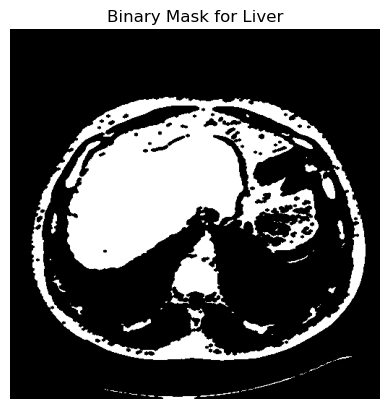

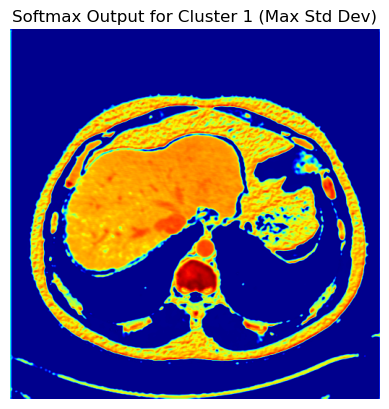

/home/23m1522/.local/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


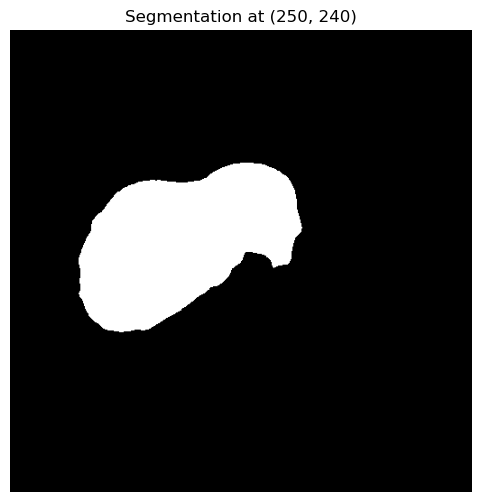

Segmentation Evaluation Metrics:
Dice Coefficient: 0.5971340206185567
intersection over union: 0.4256529343464778
Accuracy: 0.8509292602539062
Precision: 0.4458693844874834
Recall: 0.9037321350558573
False Negatives (missed liver pixels): 3085
False Positives (incorrectly predicted liver pixels): 35993
True Positives (correctly predicted liver pixels): 28961
True Negatives (correctly predicted non-liver pixels): 194105


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from scipy.signal import find_peaks
from matplotlib import cm

def find_first_minimum_after_peak(hist, start_index):
    """Find the first minimum in the histogram after the specified index."""
    for i in range(start_index + 1, len(hist) - 1):
        if hist[i] < hist[i - 1] and hist[i] < hist[i + 1]:
            return i
    return None  # If no minimum found

def test_wnet_and_segment_liver_single_image(model, hu_image, num_clusters=10):
    model.eval()
    device = 'cpu'

    # Move HU image to device and add batch and channel dimensions
    hu_image = torch.tensor(hu_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Run inference on single image
    with torch.no_grad():
        _, softmax_output, _ = model(hu_image)
    softmax_output = softmax_output.cpu().numpy().squeeze(0)  # Remove batch dimension

    # Calculate standard deviation for each cluster
    cluster_std_devs = np.zeros(num_clusters)
    for k in range(num_clusters):
        cluster_pixels = softmax_output[k, :, :]
        # Calculate standard deviation for non-zero pixels in the cluster
        cluster_std_devs[k] = np.std(cluster_pixels[cluster_pixels > 0])

    # Print all standard deviations for clusters
    print("Standard deviations for each cluster:")
    for i, std_dev in enumerate(cluster_std_devs):
        print(f"Cluster {i}: Standard Deviation = {std_dev}")

    # Select clusters with max and min standard deviation
    selected_cluster = np.argmax(cluster_std_devs)
    min_cluster = np.argmin(cluster_std_devs)
    print(f"Cluster with max standard deviation (likely liver): {selected_cluster}")
    print(f"Cluster with min standard deviation (likely background): {min_cluster}")

    # Display histograms for both selected and minimum standard deviation clusters
    cluster_output = softmax_output[selected_cluster, :, :]
    pixel_values = cluster_output[cluster_output > 0]
    
    min_cluster_output = softmax_output[min_cluster, :, :]
    min_pixel_values = min_cluster_output[min_cluster_output > 0]

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of Pixel Values for Cluster {selected_cluster} (Max Std Dev)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(min_pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of Pixel Values for Cluster {min_cluster} (Min Std Dev)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    hist, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 1))
    peaks, _ = find_peaks(hist)

    # Verify if there are at least two peaks
    if len(peaks) < 2:
        raise ValueError("Not enough peaks found in the histogram. Check the input data or clustering results.")

    # Sort peaks by height to identify larger and smaller peaks
    peak_heights = hist[peaks]
    sorted_peaks = sorted(zip(peaks, peak_heights), key=lambda x: x[1], reverse=True)
    larger_peak_idx, larger_peak_height = sorted_peaks[0]
    smaller_peak_idx, smaller_peak_height = sorted_peaks[1]

    print(f"Larger Peak: {bin_edges[larger_peak_idx]} at height {larger_peak_height}")
    print(f"Smaller Peak: {bin_edges[smaller_peak_idx]} at height {smaller_peak_height}")

    # Determine threshold based on peak positions
    if smaller_peak_idx < larger_peak_idx:
        # Case 1: Smaller peak appears before the larger peak
        first_minimum_index = find_first_minimum_after_peak(hist, smaller_peak_idx)
        if first_minimum_index is not None:
            first_minimum_value = bin_edges[first_minimum_index]
            print(f"First Minimum after smaller peak (Threshold for <): {first_minimum_value}")
            binary_mask = (cluster_output < first_minimum_value).astype(np.uint8)
        else:
            raise ValueError("No minimum found after the smaller peak.")

    else:
        # Case 2: Smaller peak appears after the larger peak
        # Find the first minimum before the smaller peak
        first_minimum_index = None
        for i in range(smaller_peak_idx - 1, -1, -1):
            if hist[i] < hist[i - 1] and hist[i] < hist[i + 1]:
                first_minimum_index = i
                break
        
        if first_minimum_index is not None:
            first_minimum_value = bin_edges[first_minimum_index]
            print(f"First Minimum before smaller peak (Threshold for >): {first_minimum_value}")
            binary_mask = (cluster_output > first_minimum_value).astype(np.uint8)
        else:
            raise ValueError("No minimum found before the smaller peak.")

    # Optional: Apply morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    return refined_mask, selected_cluster, min_cluster

# Example usage
mask, selected_cluster, min_cluster = test_wnet_and_segment_liver_single_image(model, hu_image, num_clusters=10)
softmax_outputs = []
# Disable gradient calculations
with torch.no_grad():
    image = torch.tensor(hu_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    # Get the model output
    _, softmax_output, _ = model(image)
    softmax_output = softmax_output.cpu().numpy().squeeze(0)
    num_clusters = 10
    # Move output to CPU and convert to numpy
    softmax_outputs.extend(softmax_output)
    
# Display colormap for selected and minimum standard deviation clusters
def apply_colormap(cluster_map, title):
    norm_cluster_map = (cluster_map - cluster_map.min()) / (cluster_map.max() - cluster_map.min())
    cmap_ap = cm.jet(norm_cluster_map)  # Applying the colormap
    plt.figure()
    plt.imshow(cmap_ap)
    plt.title(title)
    plt.axis('off')
    plt.show()
    return cmap_ap  # Return the colormap applied image

# Apply colormap to visualize clusters
apply_colormap(softmax_output[selected_cluster], f"Softmax Output for Cluster {selected_cluster} (Max Std Dev)")
apply_colormap(softmax_output[min_cluster], f"Softmax Output for Cluster {min_cluster} (Min Std Dev)")



def find_centroid(binary_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No contours found

    # Initialize variables to accumulate weighted coordinates and total area
    weighted_x_sum = 0
    weighted_y_sum = 0
    total_area = 0

    # Loop through each contour
    for contour in contours:
        # Calculate area of the contour
        area = cv2.contourArea(contour)
        if area == 0:
            continue  # Skip contours with zero area

        # Calculate moments for the current contour
        moments = cv2.moments(contour)
        
        # Calculate centroid coordinates for this contour
        centroid_x = moments['m10'] / area -10
        centroid_y = moments['m01'] / area -40
        
        # Accumulate weighted centroid coordinates and total area
        weighted_x_sum += centroid_x * area
        weighted_y_sum += centroid_y * area
        total_area += area

    if total_area == 0:
        return None  # No valid area found

    # Calculate the weighted average centroid
    avg_centroid_x = weighted_x_sum / total_area 
    avg_centroid_y = weighted_y_sum / total_area 

    return (avg_centroid_x, avg_centroid_y)


centroid = find_centroid(mask)
print(f"centroid of binary maks is {centroid}")


# Display the mask
plt.imshow(mask, cmap='gray')
plt.title('Binary Mask for Liver')
plt.axis('off')
plt.show()
def segment_liver_with_sam(cmap_applied, coords=None):
    # Load SAM model
    sam_checkpoint = "/home/23m1522/Wnet/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
    model_type = "vit_h"  # Model type
    device = "cpu"  # Change to "cuda" if using a GPU

    # Initialize the SAM model
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device)

    # Ensure cmap_applied is in RGB format by removing alpha channel if present
    if cmap_applied.shape[-1] == 4:  # If RGBA, remove alpha
        mask_image = cmap_applied[..., :3]
    else:
        mask_image = cmap_applied  # Already RGB

    # Generate masks for the whole image
    mask_generator = SamAutomaticMaskGenerator(sam)
    all_masks = mask_generator.generate(mask_image)  # Generate all possible masks

    if coords is not None and all_masks:
        segmented_masks = [] 

        # Check each coordinate
        for coord in coords:
            coord_x, coord_y = coord

            # Ensure coordinates are within bounds of the mask
            if coord_x < 0 or coord_x >= mask_image.shape[1] or coord_y < 0 or coord_y >= mask_image.shape[0]:
                print(f"Coordinates out of bounds: {coord}")
                continue

            found_mask = False
            # Iterate through the generated masks to find one that includes the point
            for mask in all_masks:
                if mask['segmentation'][coord_y, coord_x]:  # Check if the mask includes the coordinate
                    segmented_masks.append(mask['segmentation'])
                    found_mask = True
                    break

            if not found_mask:
                print(f"No mask found for coordinates: {coord}")

        # Visualize the segmented masks
        if segmented_masks:
            plt.figure(figsize=(8, 6))
            for i, mask in enumerate(segmented_masks):
                plt.subplot(1, len(segmented_masks), i + 1)
                plt.imshow(mask, cmap='gray')
                plt.title(f"Segmentation at {coords[i]}")
                plt.axis('off')
            plt.show()
        else:
            print("No valid masks found for the provided coordinates.")
    else:
        print("Coordinates not provided or no masks generated.")




centroid_int = tuple(map(int, centroid)) if centroid is not None else None
if centroid_int:
    cmap_applied = apply_colormap(softmax_output[selected_cluster], f"Softmax Output for Cluster {selected_cluster} (Max Std Dev)")
    segment_liver_with_sam(cmap_applied, coords=[centroid_int])
else:
    print("Centroid could not be determined.")



def evaluate_segmentation(mask, ground_truth):
    """
    Evaluate the segmentation performance using the predicted mask and ground truth.

    Parameters:
    - mask (np.ndarray): Predicted binary liver mask (1 = liver, 0 = background).
    - ground_truth (np.ndarray): Ground truth binary liver mask (1 = liver, 0 = background).

    Returns:
    - metrics (dict): Dictionary of evaluation metrics.
    """

    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = np.sum((mask == 1) & (ground_truth == 1))  # True Positives: correctly predicted liver pixels
    FP = np.sum((mask == 1) & (ground_truth == 0))  # False Positives: non-liver pixels predicted as liver
    FN = np.sum((mask == 0) & (ground_truth == 1))  # False Negatives: liver pixels missed in prediction
    TN = np.sum((mask == 0) & (ground_truth == 0))  # True Negatives: correctly predicted non-liver pixels

    # Calculate Dice Coefficient
    intersection = np.sum(mask * ground_truth)
    sum_masks = np.sum(mask) + np.sum(ground_truth)
    dice_coefficient = (2. * intersection) / sum_masks if sum_masks != 0 else 1.0
    i_o_u = (dice_coefficient/(2-dice_coefficient))
    # Calculate Accuracy, Precision, Recall, and F1 Score
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) != 0 else 1.0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    

    # Display results
    print("Segmentation Evaluation Metrics:")
    print("Dice Coefficient:", dice_coefficient)
    print("intersection over union:",i_o_u)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("False Negatives (missed liver pixels):", FN)
    print("False Positives (incorrectly predicted liver pixels):", FP)
    print("True Positives (correctly predicted liver pixels):", TP)
    print("True Negatives (correctly predicted non-liver pixels):", TN)

    # Return metrics in a dictionary
    metrics = {
        "Dice Coefficient": dice_coefficient,
        "intersection over union":i_o_u,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "False Negatives": FN,
        "False Positives": FP,
        "True Positives": TP,
        "True Negatives": TN
    }
    return metrics

metrics = evaluate_segmentation(mask, ground)

Centroid coordinates: (225.97356858418613, 202.117474483845)


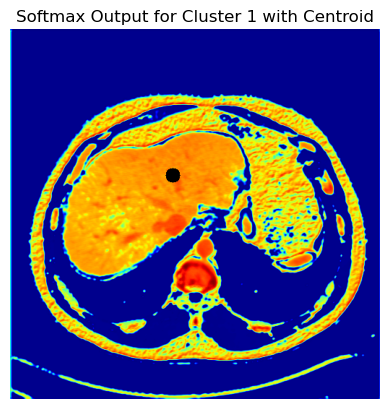

In [41]:
def mark_centroid_on_softmax(cluster_output, centroid):
    """Draws a circle at the centroid on the softmax output."""
    # Normalize cluster output for visualization
    norm_cluster_output = (cluster_output - cluster_output.min()) / (cluster_output.max() - cluster_output.min())
    color_map_applied = cm.jet(norm_cluster_output)  # Apply colormap
    color_map_applied = (color_map_applied[..., :3] * 255).astype(np.uint8)  # Convert to uint8

    # Debug: Print centroid coordinates
    print(f"Centroid coordinates: {centroid}")

    # Draw a black circle at the centroid coordinates if it's valid
    if centroid is not None:
        # Check bounds
        x, y = int(centroid[0]), int(centroid[1])
        if 0 <= x < color_map_applied.shape[1] and 0 <= y < color_map_applied.shape[0]:
            cv2.circle(color_map_applied, (x, y), 10, (0, 0, 0), -1)  # Black circle
        else:
            print("Centroid is out of bounds.")
    
    return color_map_applied

# Example usage to mark centroid on softmax output
softmax_output_image = softmax_output[selected_cluster]  # Get the softmax output for the selected cluster
softmax_with_centroid = mark_centroid_on_softmax(softmax_output_image, centroid)

# Display the softmax output with centroid
plt.imshow(softmax_with_centroid)
plt.title(f'Softmax Output for Cluster {selected_cluster} with Centroid')
plt.axis('off')
plt.show()

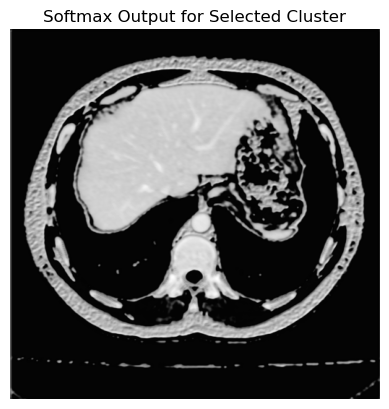

In [19]:
def plot_softmax_output(cluster_output):
    """Displays the raw softmax output for a given cluster without any color map or centroid markings."""
    plt.imshow(cluster_output, cmap='gray')  # Display in grayscale for better contrast
    plt.title('Softmax Output for Selected Cluster')
    plt.axis('off')
    plt.show()

# Example usage to plot the softmax output without modifications
softmax_output_image = softmax_output[selected_cluster]  # Get the softmax output for the selected cluster
plot_softmax_output(softmax_output_image)

In [19]:
intersection = np.sum(mask * ground)  
sum_masks = np.sum(mask) + np.sum(ground)

dice_coefficient = (2. * intersection) / sum_masks if sum_masks != 0 else 1.0
print("Dice Coefficient:", dice_coefficient)

Dice Coefficient: 0.7959594922411469


In [21]:
i_o_u = (dice_coefficient/(2-dice_coefficient))
print("intersection over union is:",i_o_u)

intersection over union is: 0.6610736824151457


In [23]:
import numpy as np

def evaluate_segmentation(mask, ground_truth):
    """
    Evaluate the segmentation performance using the predicted mask and ground truth.

    Parameters:
    - mask (np.ndarray): Predicted binary liver mask (1 = liver, 0 = background).
    - ground_truth (np.ndarray): Ground truth binary liver mask (1 = liver, 0 = background).

    Returns:
    - metrics (dict): Dictionary of evaluation metrics.
    """

    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = np.sum((mask == 1) & (ground_truth == 1))  # True Positives: correctly predicted liver pixels
    FP = np.sum((mask == 1) & (ground_truth == 0))  # False Positives: non-liver pixels predicted as liver
    FN = np.sum((mask == 0) & (ground_truth == 1))  # False Negatives: liver pixels missed in prediction
    TN = np.sum((mask == 0) & (ground_truth == 0))  # True Negatives: correctly predicted non-liver pixels

    # Calculate Dice Coefficient
    intersection = np.sum(mask * ground_truth)
    sum_masks = np.sum(mask) + np.sum(ground_truth)
    dice_coefficient = (2. * intersection) / sum_masks if sum_masks != 0 else 1.0
    i_o_u = (dice_coefficient/(2-dice_coefficient))
    # Calculate Accuracy, Precision, Recall, and F1 Score
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) != 0 else 1.0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    # Display results
    print("Segmentation Evaluation Metrics:")
    print("Dice Coefficient:", dice_coefficient)
    print("intersection over union:",i_o_u)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    print("False Negatives (missed liver pixels):", FN)
    print("False Positives (incorrectly predicted liver pixels):", FP)
    print("True Positives (correctly predicted liver pixels):", TP)
    print("True Negatives (correctly predicted non-liver pixels):", TN)

    # Return metrics in a dictionary
    metrics = {
        "Dice Coefficient": dice_coefficient,
        "intersection over union":i_o_u,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "False Negatives": FN,
        "False Positives": FP,
        "True Positives": TP,
        "True Negatives": TN
    }
    return metrics

metrics = evaluate_segmentation(mask, ground)

Segmentation Evaluation Metrics:
Dice Coefficient: 0.7959594922411469
intersection over union: 0.6610736824151457
Accuracy: 0.9393577575683594
Precision: 0.6919197554281123
Recall: 0.9368239772795939
F1 Score: 0.7959594922411469
False Negatives (missed liver pixels): 2091
False Positives (incorrectly predicted liver pixels): 13806
True Positives (correctly predicted liver pixels): 31007
True Negatives (correctly predicted non-liver pixels): 215240
